# Ticker Price Prediction
This notebook focuses on training a machine learning model to predict the future trend of a particular US stock symbol.

We will be using the `yfinance` package to download financial data for US stock symbols.

### Packages
Please ensure these packages are installed on your local environment via ```pip install -r requirements.txt``` or the corresponding package manager on your OS.

In [15]:
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

%matplotlib inline

### 1. Prerequisites & helper functions

To get started, we will define several functions for retrieving data from the Yahoo Finance API via the yfinance package.

In [18]:
def get_candlesticks(ticker_obj, period='10y', interval='1d'):
    """
    Retrieve the candlesticks of a ticker for a certain time period.
    @params ticker_obj: a yfinance Ticker object that provides access to data of a specific ticker
    @params period: a specific time period for which the candlesticks data will be retrieved
    @params interval: the interval for which to fetch candlesticks data

    @return: pandas Dataframe
    """
    return ticker_obj.history(period=period, interval=interval)

def get_last_balance_sheet(ticker_obj):
    """
    Retrieve the most recent balance sheet.
    @params ticker_obj: a yfinance Ticker object that provides access to data of a specific ticker

    @return: pandas Dataframe
    """
    return ticker_obj.balance_sheet.iloc[:, 0]

### 2. Downloading data for a specific US stock symbol

Let us download the financial data for a specified US stock symbol:

In [4]:
ticker = 'AAPL'
ticker_obj = yf.Ticker(ticker)

In [5]:
ticker_cs = get_candlesticks(ticker_obj, '10y', '1d')
ticker_cs

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-11-19 00:00:00-05:00,16.607285,17.430108,16.581793,17.375746,823317600,0.0,0.0
2012-11-20 00:00:00-05:00,17.565557,17.566785,17.033285,17.227703,642754000,0.0,0.0
2012-11-21 00:00:00-05:00,17.330287,17.426113,17.095325,17.251966,373002000,0.0,0.0
2012-11-23 00:00:00-05:00,17.419975,17.568323,17.279613,17.552965,272826400,0.0,0.0
2012-11-26 00:00:00-05:00,17.688105,18.121170,17.620842,18.106735,630579600,0.0,0.0
...,...,...,...,...,...,...,...
2022-11-11 00:00:00-05:00,145.820007,150.009995,144.369995,149.699997,93903800,0.0,0.0
2022-11-14 00:00:00-05:00,148.970001,150.279999,147.429993,148.279999,73374100,0.0,0.0
2022-11-15 00:00:00-05:00,152.220001,153.589996,148.559998,150.039993,89868300,0.0,0.0


We will be using the open price column to train our ML model, so extract the "Open" column from the dataframe:

In [9]:
ticker_open_col = ticker_cs.iloc[:, 0:1].values

This gives us a (n,1) dimensional numpy array.

In [10]:
ticker_open_col.shape

(2518, 1)

Now, we normalize the dataset:

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_training_set = scaler.fit_transform(ticker_open_col)
scaled_training_set

array([[0.0272526 ],
       [0.0329031 ],
       [0.03151582],
       ...,
       [0.82689985],
       [0.80867953],
       [0.79275878]])

Create X_train and y_train datasets:

In [25]:
X_data = []
y_data = []

for i in range(60, scaled_training_set.shape[0]):
    X_data.append(scaled_training_set[i-60:i, 0])
    y_data.append(scaled_training_set[i, 0])

X_data = np.array(X_data)
y_data = np.array(y_data)
y_data = np.reshape(y_data, (y_data.shape[0], 1))
print(X_data.shape, y_data.shape)

(2458, 60) (2458, 1)


Split the data into training and testing datasets

In [28]:
partition = round(X_data.shape[0] * 0.8)
X_train = X_data[:partition, :]
y_train = y_data[:partition, :]
X_test = X_data[partition:, :]
y_test = y_data[partition:, :]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1966, 60) (1966, 1) (492, 60) (492, 1)


Reshape the data:

In [29]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1966, 60, 1)

### 4. Build a LSTM model for time series forecasting

In [30]:
regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

Train (fit) the model:

In [31]:
regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
62/62 [==============================] - 14s 97ms/step - loss: 0.0051
Epoch 2/10
62/62 [==============================] - 6s 92ms/step - loss: 9.5799e-04
Epoch 3/10
62/62 [==============================] - 6s 94ms/step - loss: 8.4116e-04
Epoch 4/10
62/62 [==============================] - 5s 86ms/step - loss: 8.8990e-04
Epoch 5/10
62/62 [==============================] - 5s 86ms/step - loss: 8.6886e-04
Epoch 6/10
62/62 [==============================] - 5s 83ms/step - loss: 6.9338e-04
Epoch 7/10
62/62 [==============================] - 5s 85ms/step - loss: 7.3474e-04
Epoch 8/10
62/62 [==============================] - 6s 98ms/step - loss: 6.7251e-04
Epoch 9/10
62/62 [==============================] - 6s 97ms/step - loss: 6.7181e-04
Epoch 10/10
62/62 [==============================] - 6s 93ms/step - loss: 7.0002e-04


Test our model with the partitioned testing data:

In [37]:
predicted_prices = regressor.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test = scaler.inverse_transform(y_test)

16/16 [==============================] - 1s 34ms/step


Plot the predicted prices against the real prices:

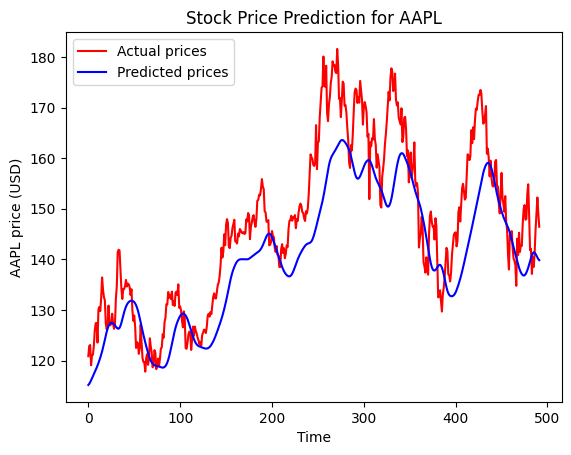

In [39]:
plt.plot(y_test, color='red', label='Actual prices')
plt.plot(predicted_prices, color='blue', label='Predicted prices')
plt.title(f"Stock Price Prediction for {ticker}")
plt.xlabel('Time')
plt.ylabel(f"{ticker} price (USD)")
plt.legend()

### 5. Evaluate results

In [43]:
print(f"Mean squared error for LSTM model: {1/y_test.shape[0]*np.mean((predicted_prices-y_test)**2)}")

Mean squared error for LSTM model: 0.18136284720530593
